In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2

In [2]:
##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210315_jfrc2018_atlas.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
# atlas = ants.from_numpy(atlas)
# atlas.set_spacing((.76,.76,.76))
# atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [3]:
atlas.shape

(1652, 768, 479)

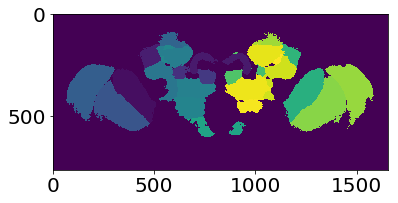

In [4]:
plt.imshow(atlas[:,:,400].T)

In [5]:
neuropiles_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210709_manual_jrc_opticlobe_neuropiles"

LO_R = os.path.join(neuropiles_path, 'LO_R.nii.gz')
LP_R = os.path.join(neuropiles_path, 'LP_R.nii.gz')
OL_R = os.path.join(neuropiles_path, 'OL_R.nii.gz')

LO_R = np.asarray(nib.load(LO_R).get_data().squeeze(), dtype='float32')
LP_R = np.asarray(nib.load(LP_R).get_data().squeeze(), dtype='float32')
OL_R = np.asarray(nib.load(OL_R).get_data().squeeze(), dtype='float32')

In [6]:
LO_R.shape

(1652, 768, 479)

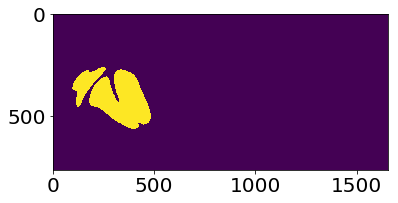

In [7]:
plt.imshow(OL_R[:,:,400].T)

In [8]:
# turn my OL into MED by subtracting LO and LP
MED_R = OL_R.copy()
MED_R[np.where(LO_R>0)] = 0
MED_R[np.where(LP_R>0)] = 0

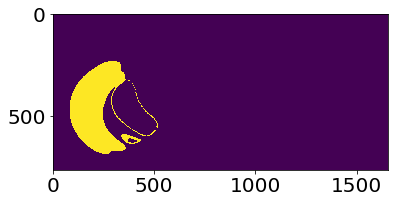

In [9]:
plt.imshow(MED_R[:,:,300].T)

In [27]:
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [65]:
MED_R_eroded = binary_erosion(MED_R, structure=np.ones((15,15,15)))

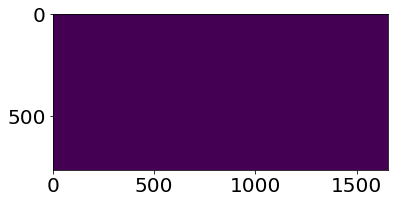

In [66]:
plt.imshow(MED_R_eroded[:,:,427].T)

In [67]:
MED_R_dilated = binary_dilation(MED_R_eroded, iterations=15)

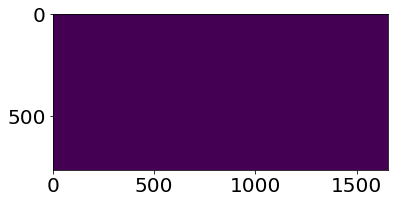

In [68]:
plt.imshow(MED_R_dilated[:,:,427].T)

In [49]:
rois={25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
71: 'MED_L',
53: 'LO_L',
69: 'LP_L'}

In [52]:
#remove bad optic lobes from atlas

for roi in rois:
    atlas[np.where(atlas==roi)] = 0.

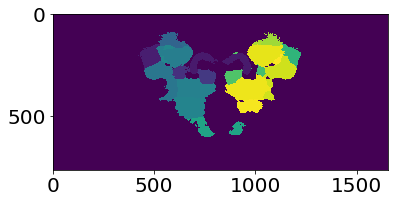

In [53]:
plt.imshow(atlas[:,:,400].T)

In [71]:
atlas_no_lobes = atlas.copy()

In [70]:
MED_R_dilated.shape

(1652, 768, 479)

In [72]:
# insert right neuropiles
atlas_no_lobes[np.where(MED_R_dilated)] = 25.
atlas_no_lobes[np.where(LO_R)] = 3.
atlas_no_lobes[np.where(LP_R)] = 22.

#insert left neuropiles
atlas_no_lobes[np.where(MED_R_dilated[::-1,:,:])] = 71.
atlas_no_lobes[np.where(LO_R[::-1,:,:])] = 53.
atlas_no_lobes[np.where(LP_R[::-1,:,:])] = 69.

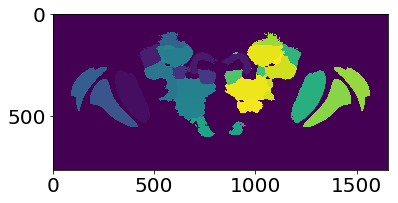

In [73]:
plt.imshow(atlas_no_lobes[:,:,400].T)

In [74]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210315_jfrc2018_atlas_OL_improve.nii'
nib.Nifti1Image(atlas_no_lobes, np.eye(4)).to_filename(save_file)